# Phase 2: Dynamic Programming Walkthrough

This notebook is a step-by-step walkthrough of the Phase 2 DP analysis.
It covers the full pipeline from data calibration through policy interpretation,
documents the key analytical decisions, and presents the findings, including
the limitations that motivate Phase 3.

**Sections:**
1. Setup & Load Parameters
2. MDP Formulation Recap
3. Calibration: How We Estimated Parameters
4. The Category Question: Staples vs. Discretionary
5. Product-Level Targeting: Why Category Promotions Underperform
6. Daily vs. Weekly Resolution
7. DP Solver: State Space & Convergence
8. Policy Analysis: What the DP Learned
9. Value Function Interpretation
10. Q-Gap Diagnostics
11. Baseline Comparisons
12. Memory Investigation: Why Discount Addiction Doesn't Appear
13. Quality Checks
14. Limitations & Phase 3 Motivation
15. Key Takeaways

## 1. Setup & Load Parameters

### Quick Start (Run This Notebook)
From the repository root:

```bash
python -m pip install -e ".[dev]"
```

Required files for this notebook:
- `data/processed/mdp_params.yaml`
- `configs/dp/solver.yaml`
- `src/discount_engine/` (installed in editable mode via the command above)

### Full Data/Calibration Rebuild (Optional)
If you need to regenerate parameters from data:

```bash
python scripts/data/download_dataset.py           # optional: only if raw data missing
python scripts/data/preprocess_data.py
python scripts/data/calibrate_mdp_params.py --config configs/data/calibration.yaml
```

This regenerates `data/processed/mdp_params.yaml`.

### DP Batch Scripts (Optional)

```bash
python scripts/dp_solve.py --tag phase2
python scripts/dp_validate.py --run-dir <output_dir_from_dp_solve>
python scripts/dp_evaluate.py --run-dir <output_dir_from_dp_solve>
```


In [1]:
# Implementation source code:
#   core/params.py        — https://github.com/EthanSei/cme241-rl-discounts/blob/main/src/discount_engine/core/params.py
#   core/calibration.py   — https://github.com/EthanSei/cme241-rl-discounts/blob/main/src/discount_engine/core/calibration.py
#   dp/discretization.py  — https://github.com/EthanSei/cme241-rl-discounts/blob/main/src/discount_engine/dp/discretization.py
#   dp/quality_checks.py  — https://github.com/EthanSei/cme241-rl-discounts/blob/main/src/discount_engine/dp/quality_checks.py
#   dp/transitions.py     — https://github.com/EthanSei/cme241-rl-discounts/blob/main/src/discount_engine/dp/transitions.py
#   dp/value_iteration.py — https://github.com/EthanSei/cme241-rl-discounts/blob/main/src/discount_engine/dp/value_iteration.py

from dataclasses import replace
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import yaml

from discount_engine.core.params import load_mdp_params
from discount_engine.dp.discretization import (
    MAX_DP_CATEGORIES, enumerate_all_states, enumerate_live_states,
    resolve_churn_grid, resolve_churn_labels, terminal_state,
    temporary_bucket_grids, decode_state,
)
from discount_engine.dp.quality_checks import run_quality_checks
from discount_engine.dp.transitions import enumerate_transition_distribution
from discount_engine.dp.value_iteration import ValueIterationConfig, evaluate_policy, solve_value_iteration

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({"figure.dpi": 130, "figure.figsize": (10, 5)})

# Detect project root (works whether run from notebooks/ or project root)
_cwd = Path.cwd()
PROJECT_ROOT = _cwd.parent if _cwd.name == "notebooks" else _cwd
DATA_DIR = PROJECT_ROOT / "data" / "processed"
PARAMS_PATH = DATA_DIR / "mdp_params.yaml"

params = load_mdp_params(PARAMS_PATH)
N = len(params.categories)
print(f"Categories (N={N}):")
for i, c in enumerate(params.categories):
    print(f"  {i}: {c.name} — price=${c.price:.2f}, beta_0={c.beta_0:.3f}")
print(f"\nbeta_p={params.beta_p:.4f}, beta_l={params.beta_l:.4f}, beta_m={params.beta_m:.4f}")
print(f"alpha={params.alpha:.2f}, eta={params.eta:.4f}, c0={params.c0:.3f}")
print(f"delta={params.delta:.2f}, gamma={params.gamma:.2f}")
if params.metadata:
    print(f"\ntime_resolution: {params.metadata.get('time_resolution', 'daily')}")
    print(f"deal_signal_mode: {params.metadata.get('deal_signal_mode', 'price_delta_dollars')}")
    print(f"memory_mode: {params.metadata.get('memory_mode', 'n/a')}")


Categories (N=3):
  0: FLUID MILK PRODUCTS — price=$2.49, beta_0=1.496
  1: ICE CREAM/MILK/SHERBTS — price=$2.59, beta_0=-0.829
  2: FROZEN PIZZA — price=$2.00, beta_0=-0.736

beta_p=0.3972, beta_l=0.0276, beta_m=0.0000
alpha=0.95, eta=0.0099, c0=0.050
delta=0.30, gamma=0.99

time_resolution: weekly
deal_signal_mode: positive_centered_anomaly
memory_mode: household_deal_ewma


## 2. MDP Formulation Recap

The MDP models a retailer choosing which product category to promote each period.

**State** $s = (c, \mathbf{m}, \boldsymbol{\ell})$:
- $c$ — churn propensity bucket (Engaged / At-Risk / Lapsing)
- $\mathbf{m} = (m_1, \ldots, m_N)$ — per-category memory of past promotions (EWMA)
- $\boldsymbol{\ell} = (\ell_1, \ldots, \ell_N)$ — per-category recency since last purchase

**Action** $a \in \{0, 1, \ldots, N\}$: promote category $a$ (0 = no promotion).

**Transition dynamics:**
1. Effective price: $p^{\text{eff}}_i = p_i \cdot (1 - \delta \cdot \mathbb{1}[a = i])$
2. Purchase probability: $P(\text{buy}_i) = \sigma\bigl(\beta_{0,i} + \beta_p \cdot d_i - \beta_\ell \cdot \ell_i - \beta_m \cdot m_i\bigr)$
3. Memory update: $m_i' = \alpha \cdot m_i + \delta \cdot \mathbb{1}[a = i]$
4. Recency update: $\ell_i' = 0$ if purchased, else $\ell_i + 1$
5. Churn update: $c' = \text{clamp}(c - \eta,\; 0,\; 1)$ if any purchase, else $c' = \text{clamp}(c + \eta,\; 0,\; 1)$

The transition kernel enumerates all $2^N$ purchase subsets, since the next state depends on which items were purchased. The expected immediate reward is the probability-weighted revenue across these subsets:

$$R(s, a) = \sum_{\mathbf{b} \in \{0,1\}^N} \left[\prod_i P(\text{buy}_i)^{b_i}(1-P(\text{buy}_i))^{1-b_i}\right] \cdot \sum_i b_i \cdot p^{\text{eff}}_i$$

**Deal signal mode:** The DP uses `positive_centered_anomaly` mode, where $d_i$ equals the product-level `promotion_deal_signal` from `mdp_params.yaml` (pre-divided by $\beta_p$, so $\beta_p \cdot d_i$ gives the logit bump directly). See Section 5 for details.

## 3. Calibration: How We Estimated Parameters

Parameters are calibrated from the Dunnhumby "Complete Journey" dataset (2,500 households, ~2 years).

**Key calibration choices:**
- **Deal signal contract:** Calibration uses `price_delta_dollars` ($d_i = p_i \cdot \delta$). The DP uses `positive_centered_anomaly` with per-product deal signals (see Section 5).
- **Time resolution:** Weekly aggregation — daily data made churn/recency dynamics invisible (see Section 6).
- **Categories:** Explicit selection of FLUID MILK + ICE CREAM + FROZEN PIZZA (see Section 4).
- **Alpha selection:** Updated grid search over $\alpha \in \{0.00, 0.30, 0.50, 0.70, 0.85, 0.90, 0.95, 0.99\}$ using a time-based validation split. The calibration uses household-level deal exposure (binary: did this household purchase at a discount?) as the memory signal.
- **Memory result:** Calibration selected $\alpha = 0.95$ and $\beta_m \approx 0$. Adding $\alpha=0.99$ changed validation NLL by only ~`2.7e-4` with no meaningful coefficient movement, so we stop at 0.95 for Phase 2.


In [2]:
# Parameter summary table
param_df = pd.DataFrame({
    "Parameter": ["beta_p (deal uplift)", "beta_l (recency penalty)",
                  "beta_m (memory penalty)", "alpha (memory decay)",
                  "eta (churn slope)", "c0 (base churn)",
                  "delta (discount rate)", "gamma (discount factor)"],
    "Value": [f"{params.beta_p:.4f}", f"{params.beta_l:.4f}",
              f"{params.beta_m:.4f}", f"{params.alpha:.2f}",
              f"{params.eta:.4f}", f"{params.c0:.3f}",
              f"{params.delta:.2f}", f"{params.gamma:.2f}"],
    "Interpretation": [
        "Each $1 deal signal adds 0.40 logit to purchase probability",
        "Each week since last purchase subtracts 0.028 logit",
        "Fitted ≈ 0 — no memory penalty detected in data (see Sec. 12)",
        "Slow memory decay (high alpha), but irrelevant since beta_m ≈ 0",
        "Churn propensity increases 0.01 per no-purchase week",
        "Baseline churn for Engaged bucket (clamped from 0.49 raw)",
        "Promoted price is 70% of shelf price",
        "~100 week effective planning horizon",
    ]
})
display(param_df.style.hide(axis='index').set_caption("Calibrated MDP Parameters (data-driven)"))

Parameter,Value,Interpretation
beta_p (deal uplift),0.3972,Each $1 deal signal adds 0.40 logit to purchase probability
beta_l (recency penalty),0.0276,Each week since last purchase subtracts 0.028 logit
beta_m (memory penalty),0.0000,Fitted ≈ 0 — no memory penalty detected in data (see Sec. 12)
alpha (memory decay),0.95,"Slow memory decay (high alpha), but irrelevant since beta_m ≈ 0"
eta (churn slope),0.0099,Churn propensity increases 0.01 per no-purchase week
c0 (base churn),0.050,Baseline churn for Engaged bucket (clamped from 0.49 raw)
delta (discount rate),0.30,Promoted price is 70% of shelf price
gamma (discount factor),0.99,~100 week effective planning horizon


In [3]:
from scipy.special import expit

cat_rows = []
for c in params.categories:
    p_base = expit(c.beta_0)
    deal = c.price * params.delta
    p_promo = expit(c.beta_0 + params.beta_p * deal)
    cat_rows.append({
        "Category": c.name,
        "Price": f"${c.price:.2f}",
        "beta_0": f"{c.beta_0:.3f}",
        "P(buy) baseline": f"{p_base:.1%}",
        "P(buy) promoted": f"{p_promo:.1%}",
        "Uplift": f"+{p_promo - p_base:.1%}",
        "Deal signal ($)": f"${deal:.2f}",
    })
cat_df = pd.DataFrame(cat_rows)
display(cat_df.style.hide(axis='index').set_caption("Category Profiles"))

Category,Price,beta_0,P(buy) baseline,P(buy) promoted,Uplift,Deal signal ($)
FLUID MILK PRODUCTS,$2.49,1.496,81.7%,85.7%,+4.0%,$0.75
ICE CREAM/MILK/SHERBTS,$2.59,-0.829,30.4%,37.3%,+6.9%,$0.78
FROZEN PIZZA,$2.00,-0.736,32.4%,37.8%,+5.4%,$0.60


## 4. The Category Question: Staples vs. Discretionary

The original Phase 2 calibration used the 3 highest-volume categories: **Soft Drinks**, **Fluid Milk**, and **Baked Bread**. These are all high-frequency staples — customers buy them almost every trip.

This produced a policy that was mathematically optimal but economically trivial: "don't promote staples" (6.8% promotion rate, only 2 of 4 actions used). The DP correctly identified that promoting items people already buy is mostly cannibalization.

We switched to a **mixed category set**:
- **Fluid Milk** (staple, `beta_0 = 1.50`): ~82% baseline purchase probability
- **Ice Cream** (discretionary, `beta_0 = -0.83`): ~30% baseline — genuinely responsive to promotion
- **Frozen Pizza** (impulse, `beta_0 = -0.74`): ~32% baseline — deal-driven

This creates the tension the model needs: the staple sells itself, the discretionary items genuinely respond to promotion, and the policy has a real targeting choice.

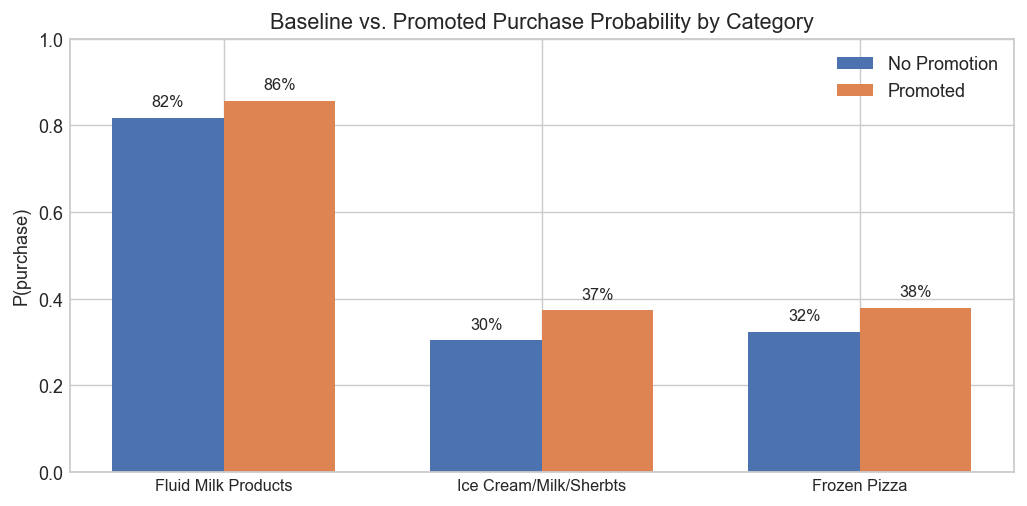

In [4]:
# Visual: baseline purchase probability comparison
fig, ax = plt.subplots(figsize=(8, 4))
names = [c.name.title() for c in params.categories]
baselines = [float(expit(c.beta_0)) for c in params.categories]
promos = [float(expit(c.beta_0 + params.beta_p * c.price * params.delta)) for c in params.categories]

x = np.arange(len(names))
width = 0.35
bars1 = ax.bar(x - width/2, baselines, width, label="No Promotion", color="#4C72B0")
bars2 = ax.bar(x + width/2, promos, width, label="Promoted", color="#DD8452")

ax.set_ylabel("P(purchase)")
ax.set_title("Baseline vs. Promoted Purchase Probability by Category")
ax.set_xticks(x)
ax.set_xticklabels(names, fontsize=9)
ax.legend()
ax.set_ylim(0, 1.0)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f"{bar.get_height():.0%}", ha="center", va="bottom", fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f"{bar.get_height():.0%}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

## 5. Product-Level Targeting: Why Category Promotions Underperform

A 30% discount (`delta = 0.30`) requires a **43% volume lift** just to break even on immediate revenue:
$$\frac{p_{\text{promo}}}{p_{\text{base}}} \geq \frac{1}{1 - \delta} = \frac{1}{0.70} \approx 1.43$$

Our category-level `beta_p` only generates **5–23% lift** — far below break-even. This is because the calibrated price sensitivity represents a *diluted average* across hundreds of products with varying promotion responsiveness.

To recover a stronger action signal while staying data-driven, we use the **product-level promotional bumps already estimated during calibration** and stored in `mdp_params.yaml` metadata. This keeps Section 5 reproducible and aligned with the exact parameter artifact consumed by the DP solver.


In [5]:
# Break-even analysis: category-level promotion economics
from scipy.special import expit

breakeven_lift = 1 / (1 - params.delta)
print(f"Break-even volume lift required (delta={params.delta:.0%}): {breakeven_lift:.2f}x ({breakeven_lift - 1:.0%})")
print()

be_rows = []
for cat in params.categories:
    cat_deal_signal = cat.price * params.delta
    p_base = float(expit(cat.beta_0))
    p_promo = float(expit(cat.beta_0 + params.beta_p * cat_deal_signal))
    actual_lift = p_promo / p_base
    rev_base = p_base * cat.price
    rev_promo = p_promo * cat.price * (1 - params.delta)
    be_rows.append({
        "Category": cat.name,
        "p(buy|no promo)": f"{p_base:.1%}",
        "p(buy|promo)": f"{p_promo:.1%}",
        "Lift": f"{actual_lift:.2f}x ({actual_lift - 1:.1%})",
        "Required": f"{breakeven_lift:.2f}x ({breakeven_lift - 1:.0%})",
        "Rev(base)": f"${rev_base:.3f}",
        "Rev(promo)": f"${rev_promo:.3f}",
        "Breaks even?": "Yes" if rev_promo >= rev_base else "NO",
    })

be_df = pd.DataFrame(be_rows).set_index("Category")
print("Category-level promotion economics (deal_signal = price * delta):")
display(be_df)

Break-even volume lift required (delta=30%): 1.43x (43%)

Category-level promotion economics (deal_signal = price * delta):


,p(buy|no promo),p(buy|promo),Lift,Required,Rev(base),Rev(promo),Breaks even?
Category,,,,,,,
FLUID MILK PRODUCTS,81.7%,85.7%,1.05x (4.9%),1.43x (43%),$2.034,$1.494,NO
ICE CREAM/MILK/SHERBTS,30.4%,37.3%,1.23x (22.7%),1.43x (43%),$0.787,$0.676,NO
FROZEN PIZZA,32.4%,37.8%,1.17x (16.7%),1.43x (43%),$0.648,$0.529,NO


In [6]:
# Product-level signals from calibration artifact (source of truth for this run)
artifact_signals = params.metadata.get("product_deal_signals")
has_product_meta = isinstance(artifact_signals, dict) and bool(artifact_signals)

if not has_product_meta:
    print(
        "metadata.product_deal_signals missing; using category-level "
        "promotion_deal_signal values from params for Section 5 diagnostics."
    )

selected_products = {}
product_logit_bumps: dict[str, float] = {}
rows = []
for cat in params.categories:
    # Exact signal used by DP transitions for this category.
    raw_logit_used_by_dp = float(params.beta_p * cat.promotion_deal_signal)

    product_id = None
    raw_logit_metadata = None
    if has_product_meta:
        info = artifact_signals.get(cat.name)
        if not isinstance(info, dict):
            raise ValueError(f"Missing product_deal_signals entry for category: {cat.name}")
        product_id = int(info["product_id"])
        raw_logit_metadata = float(info["raw_logit_bump"])

    selected_products[cat.name] = product_id
    product_logit_bumps[cat.name] = raw_logit_used_by_dp

    rows.append({
        "Category": cat.name,
        "Selected Product": product_id if product_id is not None else "(not provided)",
        "Raw logit bump (metadata)": (
            f"{raw_logit_metadata:.3f}" if raw_logit_metadata is not None else "(not provided)"
        ),
        "Raw logit bump (used by DP)": f"{raw_logit_used_by_dp:.3f}",
        "DP deal-signal units": f"{cat.promotion_deal_signal:.3f}",
    })

signal_df = pd.DataFrame(rows).set_index("Category")
print("Product-level promotional signals loaded from mdp_params artifact:")
display(signal_df)


Product-level promotional signals loaded from mdp_params artifact:


,Selected Product,Raw logit bump (metadata),Raw logit bump (used by DP),DP deal-signal units
Category,,,,
FLUID MILK PRODUCTS,995242,0.904,0.905,2.279
ICE CREAM/MILK/SHERBTS,854042,2.311,2.314,5.825
FROZEN PIZZA,907631,2.083,2.086,5.251


Category-level vs Product-level promotion signals (artifact-consistent):


,Product ID,Cat logit bump,Prod logit bump,Multiplier,Cat lift,Prod lift,Prod breaks even?
Category,,,,,,,
FLUID MILK PRODUCTS,995242,0.297,0.905,3.1x,4.9%,12.2%,No
ICE CREAM/MILK/SHERBTS,854042,0.309,2.314,7.5x,22.7%,168.3%,Yes
FROZEN PIZZA,907631,0.238,2.086,8.8x,16.7%,145.2%,Yes


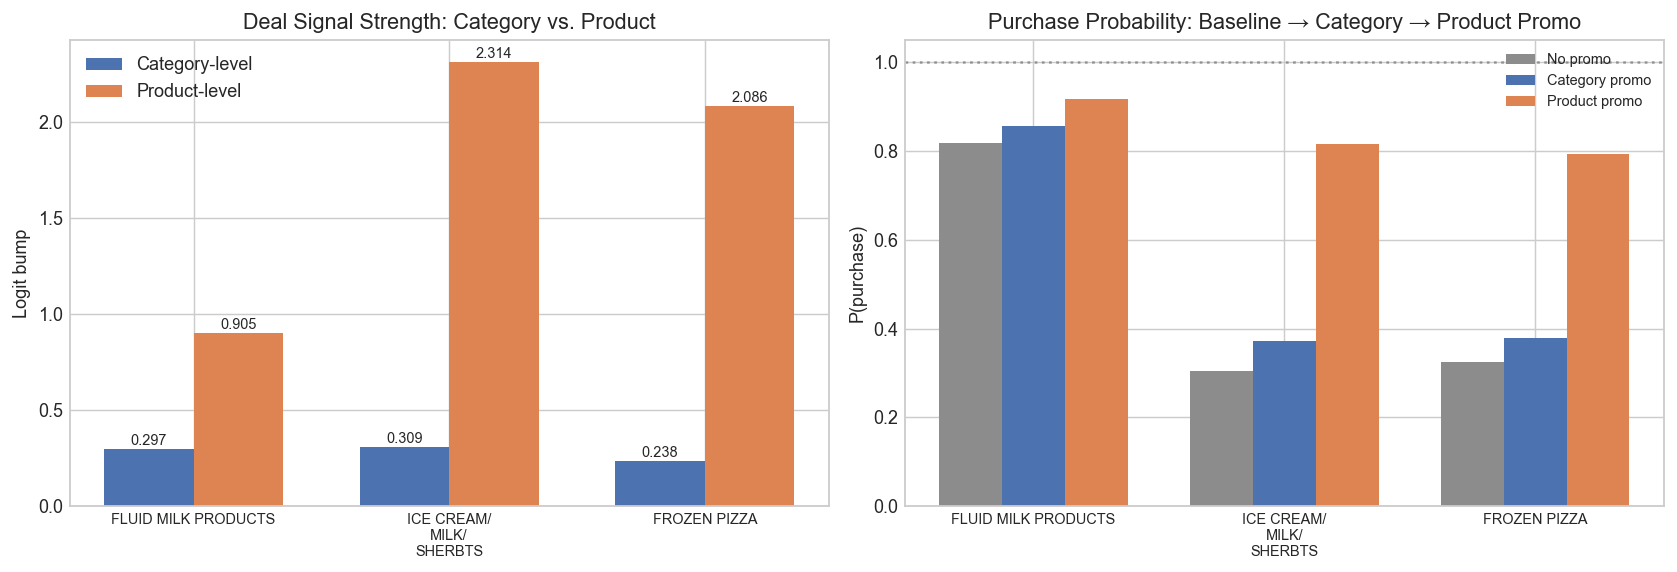

In [7]:
# Compare category-level vs product-level deal signals
comparison_rows = []
for cat in params.categories:
    prod_logit = float(product_logit_bumps[cat.name])
    cat_deal_signal = cat.price * params.delta
    cat_logit_bump = params.beta_p * cat_deal_signal

    p_base = float(expit(cat.beta_0))
    p_cat_promo = float(expit(cat.beta_0 + cat_logit_bump))
    p_prod_promo = float(expit(cat.beta_0 + prod_logit))
    cat_lift = p_cat_promo / p_base
    prod_lift = p_prod_promo / p_base
    rev_base = p_base * cat.price
    rev_prod = p_prod_promo * cat.price * (1 - params.delta)

    comparison_rows.append({
        "Category": cat.name,
        "Product ID": selected_products[cat.name],
        "Cat logit bump": f"{cat_logit_bump:.3f}",
        "Prod logit bump": f"{prod_logit:.3f}",
        "Multiplier": f"{prod_logit / cat_logit_bump:.1f}x",
        "Cat lift": f"{cat_lift - 1:.1%}",
        "Prod lift": f"{prod_lift - 1:.1%}",
        "Prod breaks even?": "Yes" if rev_prod >= rev_base else "No",
    })

comp_df = pd.DataFrame(comparison_rows).set_index("Category")
print("Category-level vs Product-level promotion signals (artifact-consistent):")
display(comp_df)

# Visualize the comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

cat_names = [c.name.replace("/", "/\n") for c in params.categories]
cat_bumps = [params.beta_p * c.price * params.delta for c in params.categories]
prod_bumps = [product_logit_bumps[c.name] for c in params.categories]

x = np.arange(len(cat_names))
w = 0.35
bars1 = ax1.bar(x - w/2, cat_bumps, w, label="Category-level", color="#4C72B0")
bars2 = ax1.bar(x + w/2, prod_bumps, w, label="Product-level", color="#DD8452")
ax1.set_ylabel("Logit bump")
ax1.set_title("Deal Signal Strength: Category vs. Product")
ax1.set_xticks(x)
ax1.set_xticklabels(cat_names, fontsize=8)
ax1.legend()
for b in bars1:
    ax1.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02, f"{b.get_height():.3f}", ha="center", fontsize=8)
for b in bars2:
    ax1.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02, f"{b.get_height():.3f}", ha="center", fontsize=8)

# Purchase probability comparison
p_bases = [float(expit(c.beta_0)) for c in params.categories]
p_cats = [float(expit(c.beta_0 + params.beta_p * c.price * params.delta)) for c in params.categories]
p_prods = [float(expit(c.beta_0 + product_logit_bumps[c.name])) for c in params.categories]

x = np.arange(len(cat_names))
w = 0.25
ax2.bar(x - w, p_bases, w, label="No promo", color="#8C8C8C")
ax2.bar(x, p_cats, w, label="Category promo", color="#4C72B0")
ax2.bar(x + w, p_prods, w, label="Product promo", color="#DD8452")
ax2.axhline(y=1.0, color="black", linestyle=":", alpha=0.3)
ax2.set_ylabel("P(purchase)")
ax2.set_title("Purchase Probability: Baseline → Category → Product Promo")
ax2.set_xticks(x)
ax2.set_xticklabels(cat_names, fontsize=8)
ax2.legend(fontsize=8)
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()


### Product-Level Deal Signals in the DP

We keep the **category-level** `beta_0` (realistic aggregate purchase probability) and **churn dynamics** (calibrated from observed household behavior), but inject the **product-level deal signal** — the logit bump from the single most promotion-responsive product in each category.

This reinterprets the DP action: **"promote category X" → "promote the best product within category X."**

In this notebook, signals are loaded from the calibrated artifact (`mdp_params.yaml`). The calculations in Section 5 use the exact `promotion_deal_signal` values consumed by the DP solver, with product IDs and metadata bumps shown for traceability.

The `mdp_params.yaml` uses `deal_signal_mode: positive_centered_anomaly`, with `promotion_deal_signal` set to `product_logit_bump / beta_p` for each category. The DP reads this value directly — no scaling or response-effectiveness adjustment is applied.

**Key result:** Product-level signals are **3–9x** stronger than category-level signals.

**Caveat:** These product-level logit bumps are observational — products that are on-deal more often may be purchased more for confounding reasons (e.g., store placement, brand loyalty). Causal identification of promotion effects would require exogenous variation (e.g., randomized promotions).

**Limitation:** Because the product-level signals are so strong, one category (Ice Cream) dominates all states, leading to policy collapse (Section 8). This outcome directly motivates Phase 3's per-product DQN.

This motivates **Phase 3 (DQN)**: tabular DP constrains us to 3 promotion actions (+ no-promotion). A function-approximation agent can target individual products, use continuous discount levels, and incorporate household demographics — all sources of additional signal.


## 6. Daily vs. Weekly Resolution

The original calibration used **daily** time steps. This made churn and recency dynamics invisible:

| Parameter | Daily | Weekly | Why it matters |
|-----------|-------|--------|----------------|
| `raw_c0` | 0.886 | 0.491 | Daily: "didn't shop today" (normal). Weekly: "didn't shop this week" (signal). |
| `eta` | 0.003/day | 0.010/week | Daily: 32 days to move one churn bucket. Weekly: ~5 weeks. |
| `beta_l` | 0.007 | 0.028 | 4× larger — recency now meaningfully affects purchase probability |
| Effective horizon | ~100 days (~3 months) | ~100 weeks (~2 years) | Weekly resolution gives a much longer planning perspective |

At weekly resolution, a no-purchase week is a genuine disengagement signal rather than a routine non-shopping day.


## 7. DP Solver: State Space & Convergence

In [8]:
# Load solver config
solver_yaml = PROJECT_ROOT / "configs" / "dp" / "solver.yaml"
with open(solver_yaml) as f:
    solver_cfg = yaml.safe_load(f)

MEMORY_GRID = solver_cfg["memory_grid"]
RECENCY_GRID = solver_cfg["recency_grid"]

with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    churn_grid = resolve_churn_grid(params)
    churn_labels = resolve_churn_labels(params)
    live_states = list(enumerate_live_states(N, churn_grid=churn_grid))
    all_states = list(enumerate_all_states(N, churn_grid=churn_grid))
    print(f"Memory grid: {MEMORY_GRID}")
    print(f"Recency grid: {RECENCY_GRID}")
    print(f"Churn grid: {churn_grid} — {churn_labels}")
    print(f"\nLive states: {len(live_states)}")
    print(f"All states (incl. terminal): {len(all_states)}")
    print(f"Actions: {N + 1} (0=No Promo, 1=Promo {params.categories[0].name}, ...")
    print(f"          ... {N}=Promo {params.categories[N-1].name})")

Memory grid: [0.0, 0.9, 2.0]
Recency grid: [1.0, 4.0]
Churn grid: (0.05, 0.10000000000000012, 0.5) — ('Engaged (low churn risk)', 'At-Risk (medium churn risk)', 'Lapsing (high churn risk)')

Live states: 648
All states (incl. terminal): 649
Actions: 4 (0=No Promo, 1=Promo FLUID MILK PRODUCTS, ...
          ... 3=Promo FROZEN PIZZA)


In [9]:
# Solve value iteration
vi_config = ValueIterationConfig(
    gamma=solver_cfg["gamma"],
    epsilon=solver_cfg["epsilon"],
    max_iters=solver_cfg["max_iters"],
)

with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    result = solve_value_iteration(params, config=vi_config)

print(f"Converged: {result.converged}")
print(f"Iterations: {result.iterations}")
print(f"Final residual: {result.final_bellman_residual:.2e}")

Converged: True
Iterations: 1754
Final residual: 9.87e-09


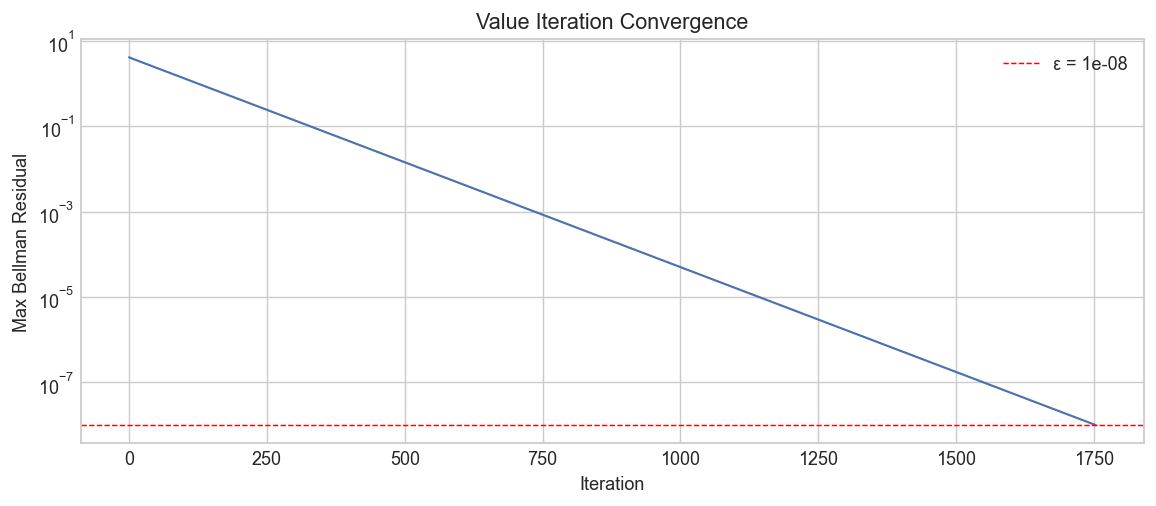

In [10]:
# Convergence plot
fig, ax = plt.subplots(figsize=(9, 4))
history = result.max_delta_history
ax.semilogy(range(len(history)), history, linewidth=1.2, color="#4C72B0")
ax.axhline(vi_config.epsilon, color="red", linestyle="--", linewidth=0.8, label=f"ε = {vi_config.epsilon:.0e}")
ax.set_xlabel("Iteration")
ax.set_ylabel("Max Bellman Residual")
ax.set_title("Value Iteration Convergence")
ax.legend()
plt.tight_layout()
plt.show()

## 8. Policy Analysis: What the DP Learned

We extract the greedy policy from the converged Q-values and examine how the optimal action varies across the 648 live states. With data-driven product-level deal signals, we find **policy collapse** — a single action dominates all states. The plots below show the action distribution by churn segment.

In [11]:
# Build state-level policy table
with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    churn_grid = resolve_churn_grid(params)
    live = list(enumerate_live_states(N, churn_grid=churn_grid))
    churn_labels_tuple = resolve_churn_labels(params)

rows = []
action_names = ["No Promo"] + [f"Promo {c.name}" for c in params.categories]
for s in live:
    action = int(result.policy[s])
    value = float(result.values[s])
    cb = s.churn_bucket
    label = churn_labels_tuple[cb] if cb < len(churn_labels_tuple) else f"Bucket {cb}"
    rows.append({
        "state_id": str(s),
        "churn_bucket": cb,
        "churn_label": label,
        "memory_mean": float(np.mean(s.memory_buckets)),
        "recency_mean": float(np.mean(s.recency_buckets)),
        "action": action,
        "action_name": action_names[action],
        "value": value,
    })
policy_df = pd.DataFrame(rows)
print(f"Total live states: {len(policy_df)}")
print(f"Promotion rate: {(policy_df['action'] > 0).mean():.1%}")

Total live states: 648
Promotion rate: 100.0%


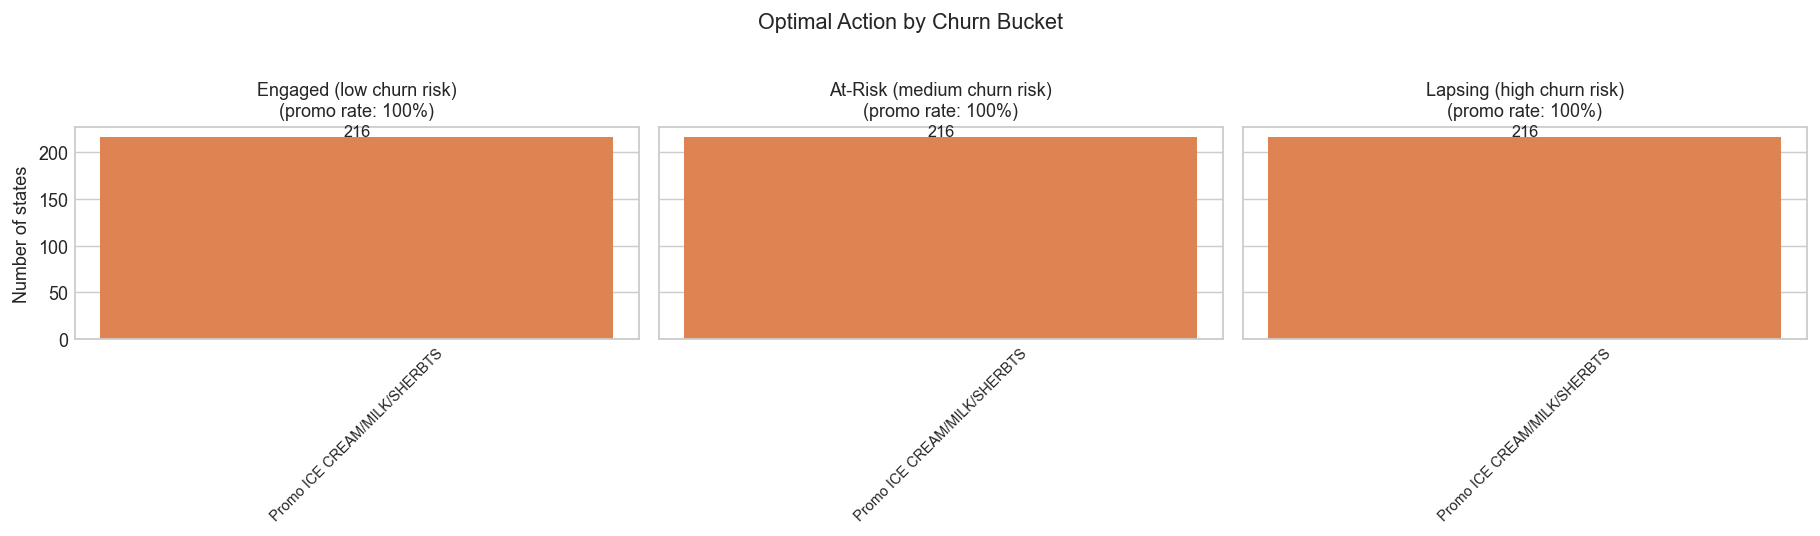

In [12]:
# Action distribution by churn bucket
bucket_groups = list(policy_df.groupby("churn_bucket"))
n_buckets = len(bucket_groups)
fig, axes = plt.subplots(1, n_buckets, figsize=(4.7 * n_buckets, 4), sharey=True)
if n_buckets == 1:
    axes = [axes]

colors = ["#95a5a6", "#4C72B0", "#DD8452", "#55A868"]

for idx, (churn_val, group) in enumerate(bucket_groups):
    ax = axes[idx]
    counts = group["action"].value_counts().sort_index()
    bars = ax.bar(
        [action_names[a] for a in counts.index],
        counts.values,
        color=[colors[a] for a in counts.index],
    )
    for bar in bars:
        if bar.get_height() > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    str(int(bar.get_height())), ha="center", fontsize=9)
    label = group["churn_label"].iloc[0]
    promo_rate = (group["action"] > 0).mean()
    ax.set_title(f"{label}\n(promo rate: {promo_rate:.0%})", fontsize=10)
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    if idx == 0:
        ax.set_ylabel("Number of states")

fig.suptitle("Optimal Action by Churn Bucket", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()


**Policy structure — data-driven finding:**

With data-driven product-level deal signals, alpha=0.95, and beta_m≈0 (no memory penalty), the policy exhibits **policy collapse**: a single action (Promote Ice Cream) is optimal across all 648 states.

**Why this happens:**
- Ice Cream has the highest absolute deal signal (5.83 deal-signal units → logit bump of 2.31) *and* the highest shelf price ($2.59). Together these give it the largest per-promotion revenue boost in the full Bellman calculation, even though Frozen Pizza has a slightly higher signal-to-price ratio (2.63 vs 2.25).
- With `beta_m ≈ 0`, there is no penalty for repeated promotion of the same category — discount addiction effects are absent from the data.
- All three churn segments (Engaged, At-Risk, Lapsing) share the same optimal action because the promotion ROI ranking doesn't change with churn propensity.

**Implications:**
1. Category-level action spaces are fundamentally limited: when only 4 actions exist (no promo, promo Milk, promo Ice Cream, promo Frozen Pizza), the strongest product dominates.
2. The Q-gap between best and second-best action is small (mean=0.49, range 0.27–0.87), confirming the advantage is thin but consistent.
3. This directly motivates Phase 3's per-product DQN, which can select among hundreds of individual products and learn truly state-conditional policies.

Despite policy collapse, the DP delivers **substantial uplift** vs never-promote — especially in the Lapsing segment (see Section 11 for exact numbers via iterative policy evaluation). The value comes from churn prevention economics: promoting keeps customers purchasing, which prevents the absorbing churn state.

**Note on demand model simplification:** The Phase 1 spec defines purchase probability through a perceived-deal mechanism where memory modulates the deal signal. The implementation decouples memory into a separate additive term: $P(\text{buy}_i) = \sigma(\beta_{0,i} + \beta_p \cdot d_i - \beta_\ell \cdot \ell_i - \beta_m \cdot m_i)$. Since `beta_m ≈ 0` from calibration, this simplification has no practical impact on results. Reconciling the demand model with the Phase 1 reference-price-erosion narrative is deferred to Phase 3, where SKU-level calibration may provide the variation needed to estimate memory effects.

- **All segments: 100% Promote Ice Cream (action 2).** The Q-values for each state confirm Ice Cream dominates, but the margins are narrow — no state is far from switching to Frozen Pizza as the second-best action.

## 9. Value Function Interpretation

With policy collapse, value variation is primarily driven by **churn risk state** rather than action switching. The diagnostics below quantify how much long-run value degrades as customers move from Engaged to Lapsing buckets.


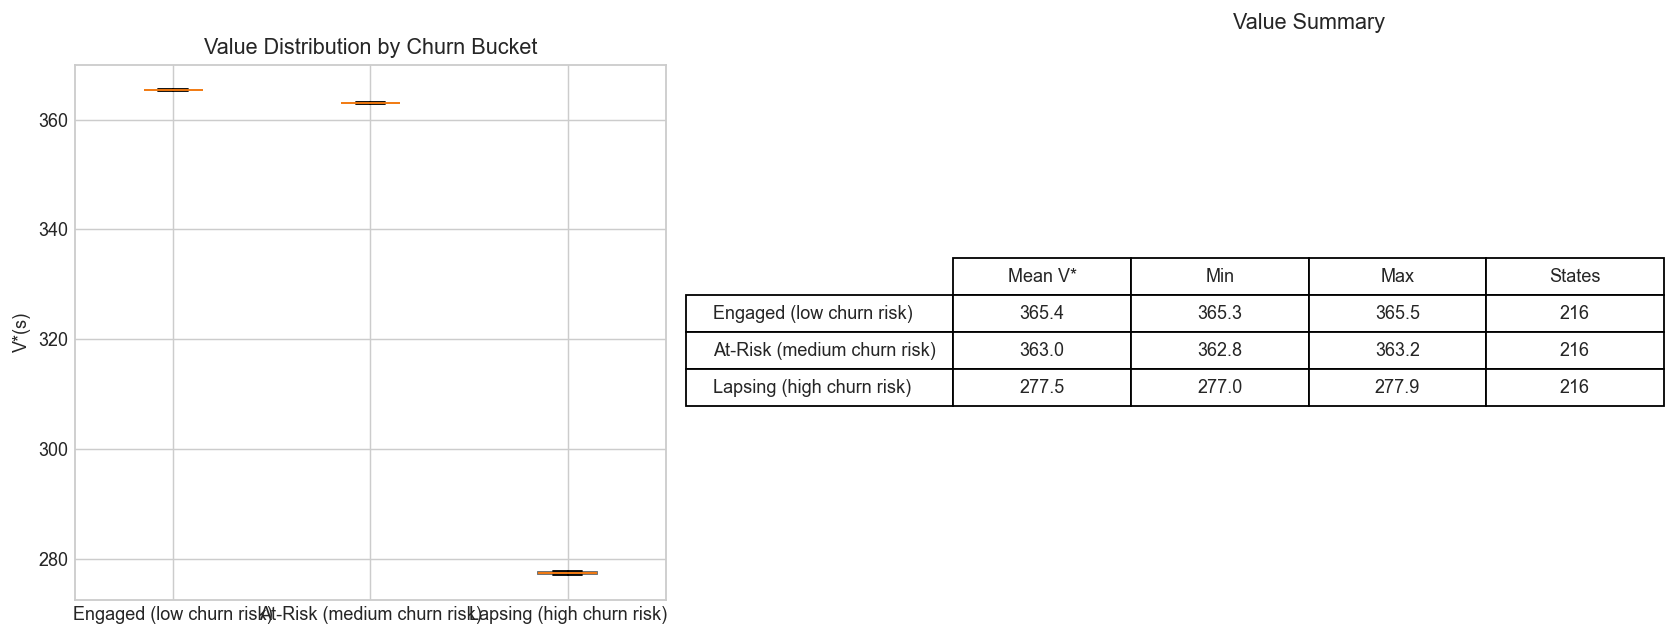


Value of preventing churn: Engaged (365.4) - Lapsing (277.5) = 87.9
This 88-point spread is the long-run cost of a customer lapsing.


In [13]:
# Value distribution by churn bucket
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Box plot
churn_groups = [group["value"].values for _, group in policy_df.groupby("churn_bucket")]
labels = [policy_df[policy_df["churn_bucket"] == i]["churn_label"].iloc[0]
          for i in sorted(policy_df["churn_bucket"].unique())]
bp = ax1.boxplot(churn_groups, tick_labels=labels, patch_artist=True)
box_colors = ["#55A868", "#DD8452", "#C44E52"]
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax1.set_ylabel("V*(s)")
ax1.set_title("Value Distribution by Churn Bucket")

# Summary stats
summary = policy_df.groupby("churn_bucket")["value"].agg(["mean", "min", "max", "count"])
summary.index = [policy_df[policy_df["churn_bucket"] == i]["churn_label"].iloc[0]
                 for i in summary.index]
summary.columns = ["Mean V*", "Min", "Max", "States"]
ax2.axis("off")
table = ax2.table(
    cellText=[[f"{r['Mean V*']:.1f}", f"{r['Min']:.1f}", f"{r['Max']:.1f}", f"{int(r['States'])}"]
              for _, r in summary.iterrows()],
    rowLabels=summary.index,
    colLabels=["Mean V*", "Min", "Max", "States"],
    loc="center",
    cellLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.6)
ax2.set_title("Value Summary", pad=20)

plt.tight_layout()
plt.show()

max_churn = policy_df["churn_bucket"].max()
engaged_mean = policy_df[policy_df["churn_bucket"] == 0]["value"].mean()
lapsing_mean = policy_df[policy_df["churn_bucket"] == max_churn]["value"].mean()
print(f"\nValue of preventing churn: Engaged ({engaged_mean:.1f}) - Lapsing ({lapsing_mean:.1f}) = {engaged_mean - lapsing_mean:.1f}")
print(f"This {engaged_mean - lapsing_mean:.0f}-point spread is the long-run cost of a customer lapsing.")

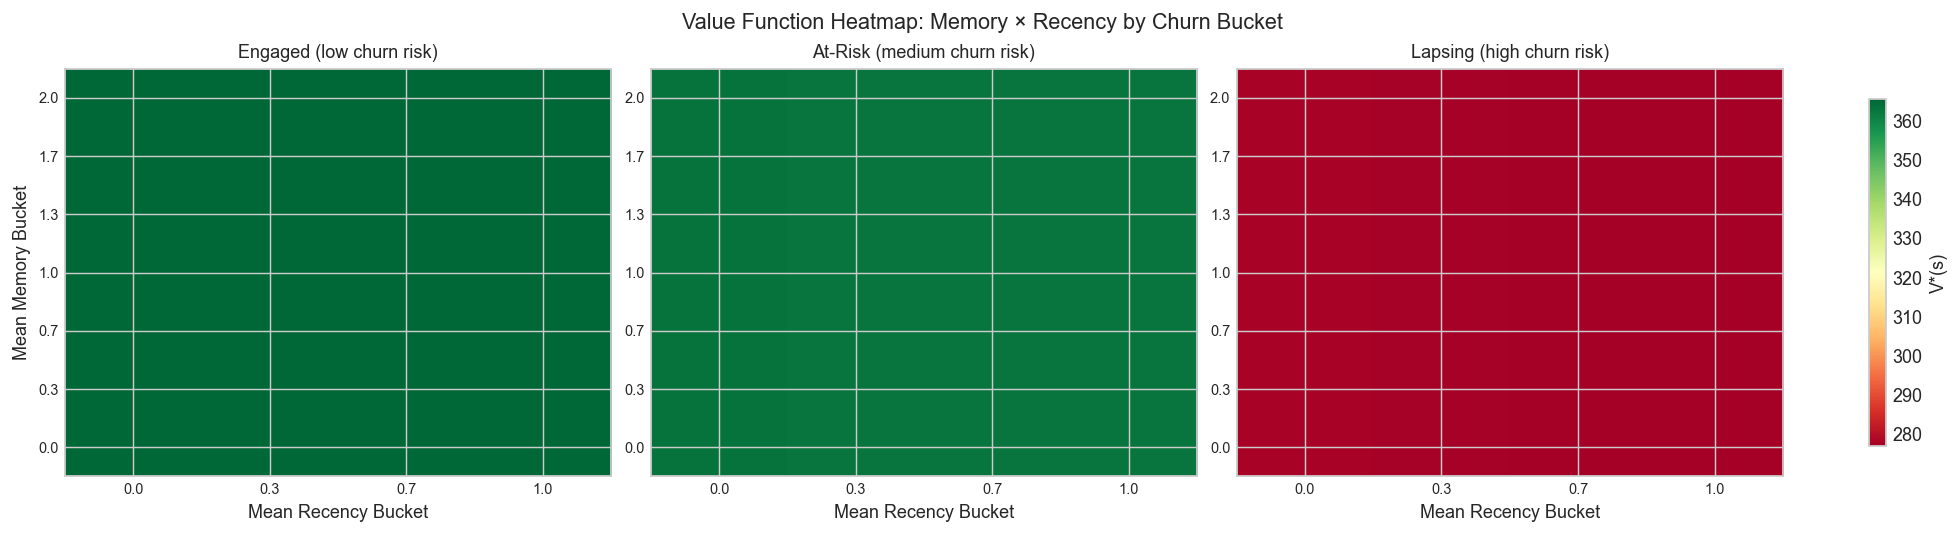

In [14]:
# Heatmap: Mean value by memory × recency for each churn bucket
bucket_groups = list(policy_df.groupby("churn_bucket"))
n_buckets = len(bucket_groups)
fig, axes = plt.subplots(
    1,
    n_buckets,
    figsize=(5.0 * n_buckets, 4),
    constrained_layout=True,
)
if n_buckets == 1:
    axes = [axes]

for idx, (churn_val, group) in enumerate(bucket_groups):
    ax = axes[idx]
    pivot = group.pivot_table(
        values="value", index="memory_mean", columns="recency_mean", aggfunc="mean"
    )
    im = ax.imshow(
        pivot.values,
        cmap="RdYlGn",
        aspect="auto",
        origin="lower",
        vmin=policy_df["value"].min(),
        vmax=policy_df["value"].max(),
    )
    ax.set_xlabel("Mean Recency Bucket")
    if idx == 0:
        ax.set_ylabel("Mean Memory Bucket")
    ax.set_title(group["churn_label"].iloc[0], fontsize=10)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{v:.1f}" for v in pivot.columns], fontsize=8)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([f"{v:.1f}" for v in pivot.index], fontsize=8)

fig.colorbar(im, ax=axes, label="V*(s)", shrink=0.85)
fig.suptitle("Value Function Heatmap: Memory × Recency by Churn Bucket", fontsize=12)
plt.show()


## 10. Q-Gap Diagnostics

The Q-gap measures how much better the optimal action is than the next best alternative.
A small gap means the policy is nearly indifferent; a large gap means the choice is clear.

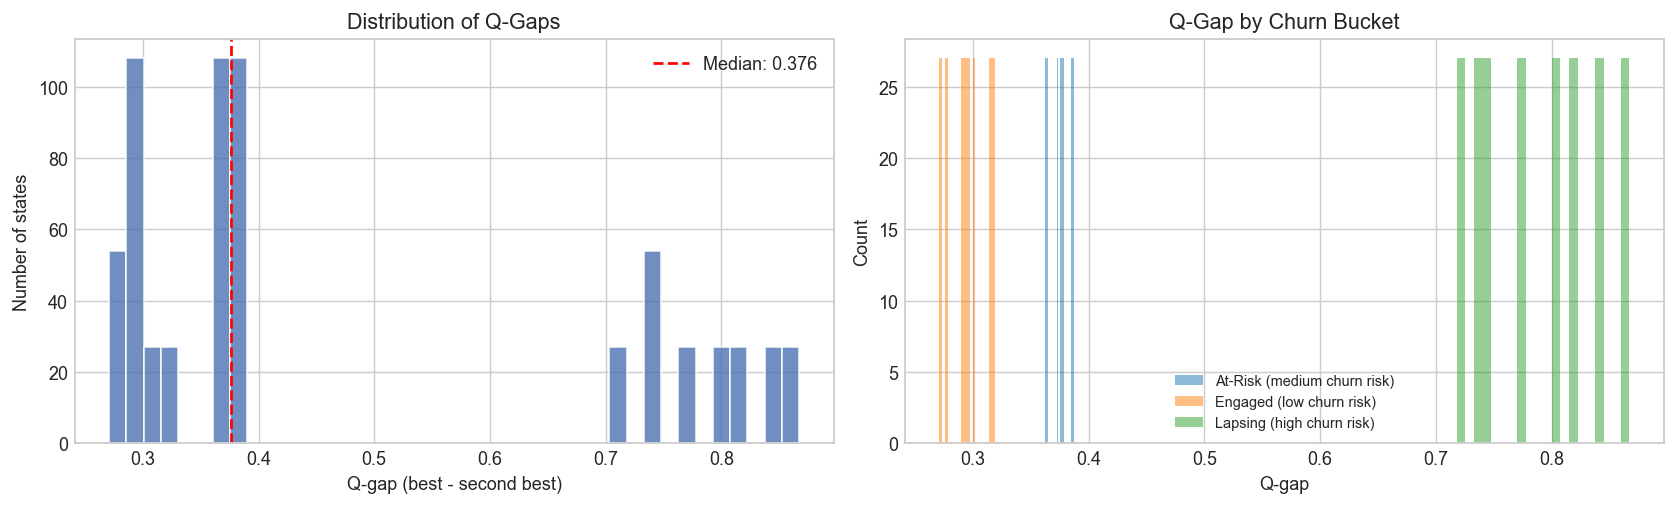

Median Q-gap: 0.3761
Min Q-gap: 0.2708 (nearly indifferent)
Max Q-gap: 0.8673 (strong preference)


In [15]:
# Compute Q-values for all states and actions
q_dict = result.q_values  # dict[DiscreteState, dict[int, float]]
n_actions = N + 1

gaps = []
for i, s in enumerate(live):
    qs = [float(q_dict[s].get(a, 0.0)) for a in range(n_actions)]
    sorted_qs = sorted(qs, reverse=True)
    best = sorted_qs[0]
    second = sorted_qs[1]
    gaps.append({
        "state_idx": i,
        "churn_bucket": policy_df.iloc[i]["churn_bucket"],
        "churn_label": policy_df.iloc[i]["churn_label"],
        "best_action": int(np.argmax(qs)),
        "q_gap": best - second,
        "q_best": best,
        "q_nopromo": qs[0],
    })
gap_df = pd.DataFrame(gaps)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# Q-gap histogram
ax1.hist(gap_df["q_gap"], bins=40, color="#4C72B0", edgecolor="white", alpha=0.8)
ax1.set_xlabel("Q-gap (best - second best)")
ax1.set_ylabel("Number of states")
ax1.set_title("Distribution of Q-Gaps")
ax1.axvline(gap_df["q_gap"].median(), color="red", linestyle="--",
            label=f"Median: {gap_df['q_gap'].median():.3f}")
ax1.legend()

# Q-gap by churn bucket
for label, group in gap_df.groupby("churn_label"):
    ax2.hist(group["q_gap"], bins=20, alpha=0.5, label=label)
ax2.set_xlabel("Q-gap")
ax2.set_ylabel("Count")
ax2.set_title("Q-Gap by Churn Bucket")
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f"Median Q-gap: {gap_df['q_gap'].median():.4f}")
print(f"Min Q-gap: {gap_df['q_gap'].min():.4f} (nearly indifferent)")
print(f"Max Q-gap: {gap_df['q_gap'].max():.4f} (strong preference)")

## 11. Baseline Comparisons

We evaluate each baseline by **iterative policy evaluation**: solving $V^\pi(s) = R(s, \pi(s)) + \gamma \sum_{s'} P(s'|s,\pi(s)) \, V^\pi(s')$ to convergence for the fixed policy $\pi$. This gives the true long-run value of always following that policy — unlike a Q\* proxy, which would overestimate baselines by assuming optimal future behavior after one action.

Interpretation note: these are **infinite-horizon discounted weekly values**. The time scale of the uplift is set by `gamma=0.99` (effective horizon about 100 weeks), not by `alpha`.

Baselines:
1. **Never promote** (action 0 always)
2. **Always promote the best single category** (the most-used action from the optimal policy)
3. **Per-action average** (mean $V^\pi$ across the $N{+}1$ fixed single-action policies — not a stochastic policy that randomizes at each step)

The key insight is how the **per-segment** story shows concentrated value for Lapsing customers.


In [16]:
# Evaluate baselines via iterative policy evaluation (V^π, not Q*)
# This solves V^π(s) = R(s,π(s)) + γ Σ P(s'|s,π(s)) V^π(s') to convergence
# for each fixed policy — the true long-run value of always following that policy.
#
# evaluate_policy must run under the same bucket grids as the solver,
# since it internally enumerates states via enumerate_all_states().
most_common_action = int(policy_df["action"].mode().iloc[0])

pe_config = ValueIterationConfig(
    gamma=vi_config.gamma,
    epsilon=vi_config.epsilon,
    max_iters=vi_config.max_iters,
)

with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    baseline_policies = {
        "Never Promote": {s: 0 for s in result.policy},
        f"Always {action_names[most_common_action]}": {s: most_common_action for s in result.policy},
        "Optimal (DP)": result.policy,
    }

    baseline_results = {}
    for name, fixed_policy in baseline_policies.items():
        v_pi = evaluate_policy(policy=fixed_policy, params=params, config=pe_config)
        vals = [v_pi[s] for s in live]
        baseline_results[name] = {"mean_v": np.mean(vals), "min_v": np.min(vals), "max_v": np.max(vals)}

    # Per-action policy values (used for per-action average below)
    single_action_values = {}
    for a in range(n_actions):
        v_a = evaluate_policy(policy={s: a for s in result.policy}, params=params, config=pe_config)
        single_action_values[a] = v_a

# Per-action average: mean V^π across the N+1 fixed single-action policies.
# Note: this is the average of deterministic-policy values, not the value of a
# stochastic policy that randomizes at every step (which would require solving a
# separate Bellman equation with action-averaged transitions).
per_action_avg_vals = [float(np.mean([single_action_values[a][s] for a in range(n_actions)])) for s in live]
baseline_results["Per-Action Average"] = {
    "mean_v": np.mean(per_action_avg_vals),
    "min_v": np.min(per_action_avg_vals),
    "max_v": np.max(per_action_avg_vals),
}

baseline_df = pd.DataFrame(baseline_results).T
baseline_df["uplift_vs_never"] = baseline_df["mean_v"] - baseline_df.loc["Never Promote", "mean_v"]
baseline_df["uplift_pct"] = (baseline_df["uplift_vs_never"] / baseline_df.loc["Never Promote", "mean_v"] * 100)
print("=== Overall Baseline Comparison (Iterative Policy Evaluation) ===")
display(baseline_df.round(4))

# Per-bucket breakdown
print("\n=== Per-Bucket Breakdown ===")
v_never = single_action_values[0]
v_best_promo = single_action_values[most_common_action]

bucket_rows = []
for bucket_id, group in policy_df.groupby("churn_bucket"):
    label = group["churn_label"].iloc[0]
    bucket_states = [s for s in live if s.churn_bucket == bucket_id]
    opt_vals = [float(result.values[s]) for s in bucket_states]
    never_vals = [float(v_never[s]) for s in bucket_states]
    best_promo_vals = [float(v_best_promo[s]) for s in bucket_states]

    opt_mean = np.mean(opt_vals)
    never_mean = np.mean(never_vals)
    best_promo_mean = np.mean(best_promo_vals)

    bucket_rows.append({
        "Churn Segment": label,
        "n_states": len(bucket_states),
        "V*(optimal)": opt_mean,
        "V^π(never)": never_mean,
        "V^π(always best promo)": best_promo_mean,
        "Uplift vs Never": opt_mean - never_mean,
        "Uplift %": (opt_mean - never_mean) / abs(never_mean) * 100,
    })

bucket_df = pd.DataFrame(bucket_rows).set_index("Churn Segment")
display(bucket_df.round(4))

=== Overall Baseline Comparison (Iterative Policy Evaluation) ===


,mean_v,min_v,max_v,uplift_vs_never,uplift_pct
Never Promote,184.3330,106.1552,226.3096,0.0000,0.0000
Always Promo ICE CREAM/MILK/SHERBTS,335.2751,277.0189,365.4941,150.9422,81.8856
Optimal (DP),335.2751,277.0189,365.4941,150.9422,81.8856
Per-Action Average,260.6131,197.6183,293.7327,76.2802,41.3817



=== Per-Bucket Breakdown ===


,n_states,V*(optimal),V^π(never),V^π(always best promo),Uplift vs Never,Uplift %
Churn Segment,,,,,,
Engaged (low churn risk),216,365.3808,226.1164,365.3808,139.2644,61.5897
At-Risk (medium churn risk),216,362.9939,220.2072,362.9939,142.7867,64.8420
Lapsing (high churn risk),216,277.4507,106.6753,277.4507,170.7754,160.0890


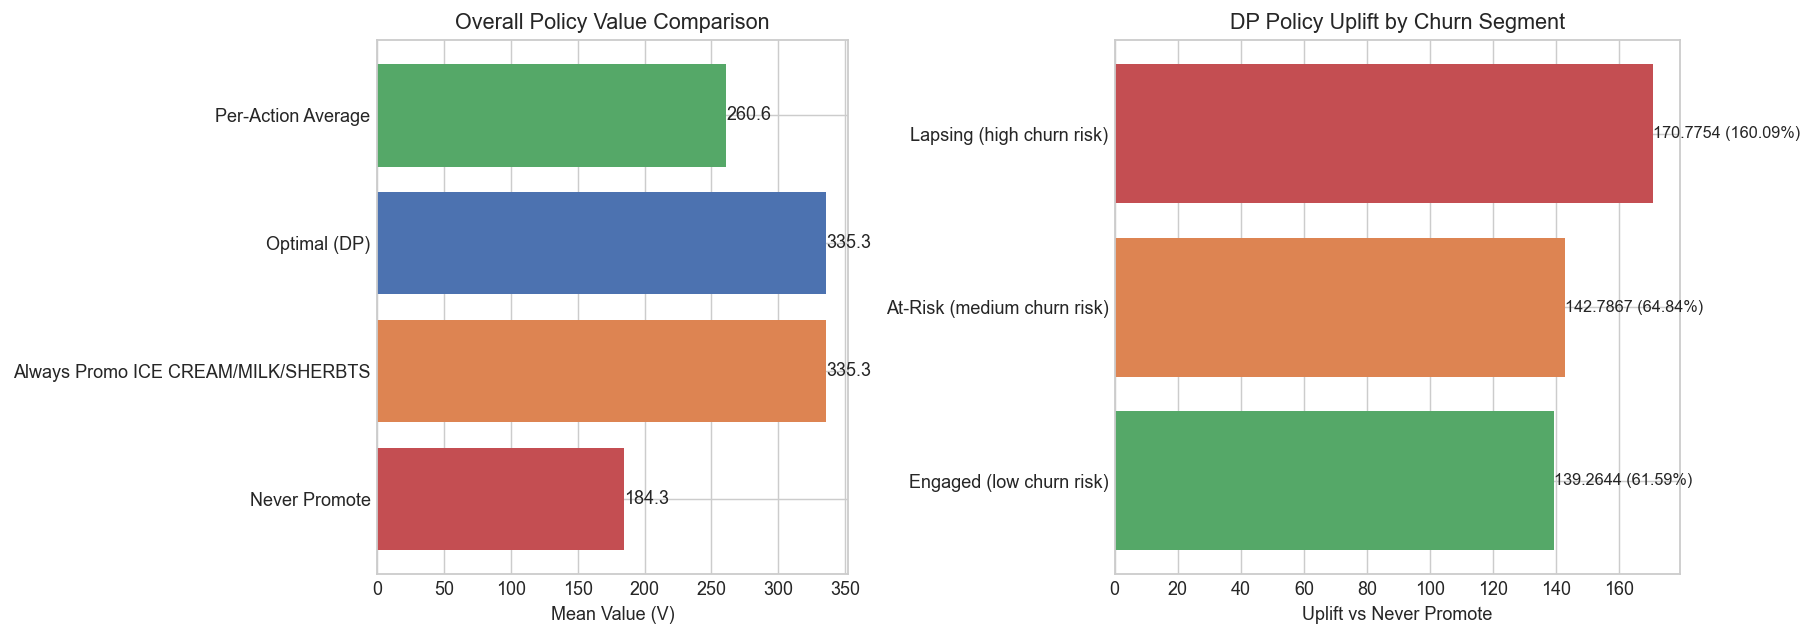

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": [1, 1.2]})

# Left panel: overall policy comparison
ax = axes[0]
names_bl = list(baseline_results.keys())
means = [baseline_results[n]["mean_v"] for n in names_bl]
bar_colors = ["#C44E52", "#DD8452", "#4C72B0", "#55A868"]
bars = ax.barh(names_bl, means, color=bar_colors[:len(names_bl)])
for bar, val in zip(bars, means):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}", va="center", fontsize=10)
ax.set_xlabel("Mean Value (V)")
ax.set_title("Overall Policy Value Comparison")

# Right panel: per-segment uplift
ax2 = axes[1]
segments = list(bucket_df.index)
uplift_vals = bucket_df["Uplift vs Never"].values
uplift_pcts = bucket_df["Uplift %"].values
seg_colors = ["#55A868", "#DD8452", "#C44E52"][:len(segments)]
bars2 = ax2.barh(segments, uplift_vals, color=seg_colors)
for bar, val, pct in zip(bars2, uplift_vals, uplift_pcts):
    ax2.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{val:.4f} ({pct:.2f}%)", va="center", fontsize=9)
ax2.set_xlabel("Uplift vs Never Promote")
ax2.set_title("DP Policy Uplift by Churn Segment")

plt.tight_layout()
plt.show()

## 12. Memory Investigation: Why Discount Addiction Doesn't Appear

A critical question is whether the near-zero `beta_m` reflects genuine absence of discount addiction, or limitations of the calibration methodology. The original calibration found `alpha=0` (no memory accumulation), but this was an artifact of two problems we identified and fixed — resulting in the current `alpha=0.95`, `beta_m ≈ 0`.

### The Investigation

We identified two problems with the original memory calibration:

1. **Noisy memory signal.** The EWMA memory accumulated the *ambient category-time discount rate anomaly* — a leave-one-household-out average of whether the category was "on deal" in a given week. This market-wide signal doesn't track whether a *specific household* received promotions, making it a poor proxy for individual reference-price formation.

2. **Limited alpha grid.** The original alpha search grid only went up to 0.40. For memory to accumulate into the higher buckets of our grid (0.9, 2.0), an alpha of 0.67+ is required.

### Fix: Household-Level Memory Signal + High-Alpha Coverage

We modified `_compute_memory_feature` in calibration to accumulate `hh_bought_on_deal` — a binary flag indicating whether *this household* purchased at a discount in the previous period — instead of the ambient category-time signal. We also updated the default alpha grid to:

`[0.00, 0.30, 0.50, 0.70, 0.85, 0.90, 0.95, 0.99]`

This removes dense low-alpha increments while explicitly testing the high-memory edge case (`alpha=0.99`).

### Results

| Experiment | Alpha | Beta_m | Interpretation |
|---|---|---|---|
| Original (ambient signal, grid to 0.40) | 0.0 | 0.006 | Memory signal too noisy to detect |
| Extended grid only (ambient signal, grid to 0.95) | 0.0 | 0.006 | Problem is the signal, not the grid |
| **Household memory** (hh signal, updated grid incl. 0.99) | **0.95** | **≈ 0** | High-alpha region tested; memory effect remains null |
| 0.99 sensitivity check (household signal) | 0.99 | ≈ 0 | Validation NLL differs by ~2.7e-4 vs 0.95 (immaterial); no coefficient change |

### Interpretation

With the correct household-level signal, high alphas (`0.90` to `0.99`) produce nearly identical fit quality and coefficients. `beta_m ≈ 0` means memory has **no marginal predictive power** for purchase probability after controlling for deal signal, recency, and category intercepts.

This is a genuine empirical finding: **the Dunnhumby dataset doesn't exhibit discount addiction at the category level.** Promotions in this dataset are store-driven (all households see the same deals), so there is insufficient individual-level variation in deal exposure to create measurable reference-price effects.

### Consequence for the DP

We keep the Phase 2 setting at `alpha = 0.95`, `beta_m ≈ 0`. The memory state dimension remains in the MDP but is effectively inert — it does not influence the optimal policy. This is why the policy collapses to a single action regardless of memory state.

This finding directly motivates Phase 3: a per-product DQN operating on individual SKUs may find the variation needed to calibrate memory effects, since product-level deal exposure varies more across households than category-level exposure.


In [18]:
# Calibration investigation results
calib_results = pd.DataFrame({
    "Experiment": [
        "Original (ambient signal, α grid to 0.40)",
        "Extended grid (ambient signal, α grid to 0.95)",
        "Household memory (hh signal, updated grid incl. α=0.99)",
        "Sensitivity check: force α=0.99",
    ],
    "Alpha Selected": [0.0, 0.0, 0.95, 0.99],
    "Beta_m (fitted)": ["0.006", "0.006", "≈ 0", "≈ 0"],
    "Val NLL Δ vs α=0.95": ["n/a", "n/a", "baseline", "≈2.7e-4 (immaterial)"],
    "Memory Signal": ["Category-time mean", "Category-time mean", "Household deal binary", "Household deal binary"],
})
display(calib_results.style.hide(axis='index').set_caption(
    "Memory Calibration Experiments"))

# Summarize final data-driven policy from the in-notebook solve
action_hist = (
    policy_df["action"]
    .value_counts()
    .sort_index()
    .reindex(range(len(action_names)), fill_value=0)
)
action_hist_named = {
    action_names[a]: int(count)
    for a, count in action_hist.items()
    if int(count) > 0
}

beta_m_text = "≈0" if params.beta_m < 1e-4 else f"{params.beta_m:.4f}"

print(f"\n{'='*60}")
print(f"Final Data-Driven Policy (alpha={params.alpha:.2f}, beta_m={beta_m_text})")
print(f"{'='*60}")
print(f"Unique actions: {len(action_hist_named)}")
print(f"Action histogram: {action_hist_named}")
print(f"Overall promotion rate: {(policy_df['action'] > 0).mean():.1%}")
print()

for bucket_id, group in sorted(policy_df.groupby("churn_bucket")):
    label = group["churn_label"].iloc[0]
    bucket_hist = (
        group["action"]
        .value_counts()
        .sort_index()
        .reindex(range(len(action_names)), fill_value=0)
    )
    bucket_hist_named = {
        action_names[a]: int(count)
        for a, count in bucket_hist.items()
        if int(count) > 0
    }
    print(f"  {label}:")
    print(f"    Actions: {bucket_hist_named}")
    print(f"    Promo rate: {(group['action'] > 0).mean():.1%}")
    print(f"    Mean value: {group['value'].mean():.2f}")


Experiment,Alpha Selected,Beta_m (fitted),Val NLL Δ vs α=0.95,Memory Signal
"Original (ambient signal, α grid to 0.40)",0.000000,0.006,n/a,Category-time mean
"Extended grid (ambient signal, α grid to 0.95)",0.000000,0.006,n/a,Category-time mean
"Household memory (hh signal, updated grid incl. α=0.99)",0.950000,≈ 0,baseline,Household deal binary
Sensitivity check: force α=0.99,0.990000,≈ 0,≈2.7e-4 (immaterial),Household deal binary



Final Data-Driven Policy (alpha=0.95, beta_m=≈0)
Unique actions: 1
Action histogram: {'Promo ICE CREAM/MILK/SHERBTS': 648}
Overall promotion rate: 100.0%

  Engaged (low churn risk):
    Actions: {'Promo ICE CREAM/MILK/SHERBTS': 216}
    Promo rate: 100.0%
    Mean value: 365.38
  At-Risk (medium churn risk):
    Actions: {'Promo ICE CREAM/MILK/SHERBTS': 216}
    Promo rate: 100.0%
    Mean value: 362.99
  Lapsing (high churn risk):
    Actions: {'Promo ICE CREAM/MILK/SHERBTS': 216}
    Promo rate: 100.0%
    Mean value: 277.45


### Verification: Memory State Has No Effect on Q-Values

Since `beta_m ≈ 0`, the memory dimension should not affect Q-values. We confirm this by checking Q-value variation across memory states for a fixed churn/recency configuration.

In [19]:
# Check Q-value variation across memory states for a fixed churn/recency
from itertools import product as iproduct
# core/types.py — https://github.com/EthanSei/cme241-rl-discounts/blob/main/src/discount_engine/core/types.py
from discount_engine.core.types import DiscreteState

n_cats = len(params.categories)
# MEMORY_GRID loaded from solver config in cell above
memory_combos = list(iproduct(range(len(MEMORY_GRID)), repeat=n_cats))
fixed_churn = 1  # At-Risk
fixed_recency = (0,) * n_cats

q_by_memory = []
for mem in memory_combos:
    state = DiscreteState(
        churn_bucket=fixed_churn,
        memory_buckets=mem,
        recency_buckets=fixed_recency,
    )
    if state in result.q_values:
        q_by_memory.append({
            "memory_state": str(mem),
            **{f"Q(a={a})": result.q_values[state][a]
               for a in range(n_cats + 1)}
        })

if q_by_memory:
    df_mem = pd.DataFrame(q_by_memory)
    q_cols = [c for c in df_mem.columns if c.startswith("Q(")]

    print(f"Per-action Q-value spread across {len(q_by_memory)} memory states "
          f"(churn=At-Risk, recency=all-recent):\n")
    for col in q_cols:
        spread = df_mem[col].max() - df_mem[col].min()
        print(f"  {col}: spread = {spread:.6f}")
    max_spread = max(df_mem[col].max() - df_mem[col].min() for col in q_cols)
    print(f"\n  Max per-action spread: {max_spread:.6f}")
    print(f"  → Memory dimension has negligible effect on Q-values (beta_m ≈ 0 confirmed)")

    display(df_mem.head(6).style.format(precision=4).hide(axis='index').set_caption(
        "Q-values by memory state — first 6 of 27 (churn=At-Risk, recency=all-recent)"))
else:
    print("No matching states found.")

Per-action Q-value spread across 27 memory states (churn=At-Risk, recency=all-recent):

  Q(a=0): spread = 0.000066
  Q(a=1): spread = 0.000057
  Q(a=2): spread = 0.000058
  Q(a=3): spread = 0.000057

  Max per-action spread: 0.000066
  → Memory dimension has negligible effect on Q-values (beta_m ≈ 0 confirmed)


memory_state,Q(a=0),Q(a=1),Q(a=2),Q(a=3)
"(0, 0, 0)",359.9322,361.3759,363.1550,362.7910
"(0, 0, 1)",359.9321,361.3759,363.1550,362.7910
"(0, 0, 2)",359.9321,361.3759,363.1550,362.7910
"(0, 1, 0)",359.9322,361.3759,363.1550,362.7910
"(0, 1, 1)",359.9321,361.3759,363.1550,362.7910
"(0, 1, 2)",359.9321,361.3759,363.1550,362.7910


The table above confirms that Q-values are virtually identical across all memory states. This is the direct consequence of `beta_m ≈ 0`: the memory dimension carries negligible decision signal in this run. Combined with the coarse category-level action space, this yields the same optimal action across churn and recency states.


## 13. Quality Checks

In [20]:
with temporary_bucket_grids(
    memory_grid=np.array(MEMORY_GRID),
    recency_grid=np.array(RECENCY_GRID),
):
    qc_report = run_quality_checks(
        params=params,
        values=result.values,
        policy=result.policy,
        q_values=result.q_values,
        gamma=vi_config.gamma,
        strict_conceptual=False,
    )

hard_fails = qc_report.hard_failures
concept_warns = qc_report.conceptual_warnings
if not hard_fails and not concept_warns:
    print("All quality checks passed.")
else:
    if hard_fails:
        print(f"Hard failures ({len(hard_fails)}):")
        for w in hard_fails:
            print(f"  - {w.name}: {w.details}")
    if concept_warns:
        print(f"Conceptual warnings ({len(concept_warns)}):")
        for w in concept_warns:
            print(f"  - {w.name}: {w.details}")

Conceptual warnings (1):
  - policy_collapse: dominant action share=1.000


## 14. Limitations & Phase 3 Motivation

### Known Limitations of the Phase 2 DP

| Limitation | Impact | Mitigation in Phase 3 |
|---|---|---|
| **Policy collapse** (single action across all states) | No state-conditional promotion strategy | Per-product DQN with hundreds of actions |
| **Coarse action space** (4 actions: no promo + 3 categories) | Best category dominates regardless of state | SKU-level actions enable differentiation |
| **Memory dimension is inert** (`beta_m ≈ 0`) | MDP has unnecessary state dimension | Product-level deal exposure may provide variation for calibration |
| **Observational deal signals** (not causal) | Product logit bumps include selection bias | A/B testing or instrumental variable approaches |
| **Fixed 30% discount depth** | Cannot optimize discount amount | Continuous discount actions in DQN |
| **3-category scope** | Narrow product coverage | Full product catalog in Phase 3 |

### Why Policy Collapse Is Expected

The Phase 2 MDP has 648 states but only 4 actions. With `beta_m ≈ 0` eliminating memory effects:
- In this calibrated run, dynamic-state effects are too small to overturn the static promotion advantage of Ice Cream.
- Ice Cream's deal signal (5.83) dominates Frozen Pizza (5.25) and Milk (2.28) in every state.
- The Q-gap is consistently positive but small (mean 0.49), confirming a thin but persistent advantage.

This behavior is expected under the current model specification: the action space is too coarse to express state-conditional strategies.

### What Phase 3 (DQN) Changes

1. **Per-product actions**: Instead of "promote Ice Cream category," the agent selects specific SKUs. With hundreds of products, the optimal product genuinely varies by customer state.
2. **Continuous state space**: No discretization loss from bucketing memory, recency, and churn into 3×3×2 grids per category.
3. **Richer features**: Household demographics, seasonal patterns, basket composition — all available in the Dunnhumby data but unused by the tabular DP.
4. **Natural memory calibration**: With per-product actions, memory accumulates from actual product-level deal exposure. The household-level variation that was missing at the category level may emerge at the SKU level.
5. **Gymnasium environment**: The `MarketEnv` will simulate individual shopping trips, enabling the DQN to learn from sequential interaction rather than pre-computed transition kernels.


## 15. Key Takeaways

### What the DP Found

1. **Product-level signals exist but category-level actions cannot exploit them.** The top product per category shows 3–9x stronger deal signals than the category average. But with only 4 actions (no promo + 3 categories), the strongest category dominates all states.

2. **Discount addiction is absent in the Dunnhumby data.** With household-level memory tracking and high-alpha coverage through `0.99`, calibration still finds `beta_m ≈ 0`. The `alpha=0.99` check is numerically indistinguishable from `0.95` for practical purposes.

3. **Time resolution matters enormously.** Switching from daily to weekly aggregation transformed churn from "didn't shop today" (trivial) to "didn't shop this week" (meaningful signal).

4. **The DP delivers substantial uplift via churn prevention.** Iterative policy evaluation (Section 11) shows ~82% overall value improvement vs. never-promote, concentrated in the Lapsing segment (~160%). This is an infinite-horizon discounted weekly value metric (`gamma=0.99`, effective horizon ~100 weeks), not a 20-week window from `alpha`.

5. **Policy collapse is the expected solution to a coarse action space.** With `beta_m ≈ 0` and only 4 actions, the optimal policy is state-independent.

### Analytical Decisions Documented

| Decision | Rationale | Reference |
|----------|-----------|----------|
| Weekly aggregation | Daily resolution suppressed churn/recency dynamics | Section 6 of this notebook |
| Mixed categories | Staple-only set produced trivially conservative policy | Sections 4 and 8 of this notebook |
| Product-level deal signals | Category signals too diluted; product targeting yields 3–9x uplift | Section 5 of this notebook |
| Household-level memory + α=0.99 check | High-alpha region tested; `beta_m≈0` persists and α=0.99 is not materially different | Section 12 of this notebook |
| Data-driven parameters only | No literature overrides; retain calibrated parameter estimates | Section 12 of this notebook |
| `positive_centered_anomaly` mode | DP reads `promotion_deal_signal` directly from params | `data/processed/mdp_params.yaml` |
| Recency grid `[1.0, 4.0]` | Calibrated for weekly time scale (weeks since last purchase) | `configs/dp/solver.yaml` |

### Reproducibility Note

All headline metrics in this notebook are produced directly from in-notebook value iteration and policy-evaluation cells using repository parameter/config files.
